In [2]:
# coding: utf-8
"""
・cabochaによる構文取得
・頻度を数え上げる
・bag of wordsを作成する
"""
import CaboCha
import xml.etree.ElementTree as ET
from collections import Counter
import csv
import matplotlib.pyplot as plt
%matplotlib inline

# csvファイルの読み込み
def readcsv(path):
    f = open(path, "rb")
    dataReader = csv.reader(f)
    arr = [row for row in dataReader]
    return arr

def parsing(sentence):
    # cabochaのインスタンス化
    c = CaboCha.Parser()
    # 構文解析の結果をxmlで受け取る
    xml = c.parse(sentence).toString(CaboCha.FORMAT_XML)
    root = ET.fromstring(xml)
    list_chunk = root.findall(".//chunk")
    
    # 後で処理しやすいようにdict型にしておく
    dict_chunk = {}
    # 後で順位和検定をするためにbag_of_wordsの作成をしておく
    list_bag_of_words = []
    for i, chunk in enumerate(list_chunk):
        dict_chunk_tok = {"id": int(chunk.attrib["id"]),
                          "link": int(chunk.attrib["link"]),
                          "head": int(chunk.attrib["head"]),
                          "tok_id": [int(tok.attrib["id"]) for tok in chunk.findall(".//tok")],
                          "tok_pos1": [tok.attrib["feature"].split(",")[0].encode("utf-8") for tok in chunk.findall(".//tok")],
                          "tok_pos2": [tok.attrib["feature"].split(",")[1].encode("utf-8") for tok in chunk.findall(".//tok")],
                          "tok_word": [tok.attrib["feature"].split(",")[6].encode("utf-8") for tok in chunk.findall(".//tok")]}
        dict_chunk[i] = dict_chunk_tok
        list_bag_of_words.extend([tok.attrib["feature"].split(",")[6] for tok in chunk.findall(".//tok") if tok.attrib["feature"].split(",")[0].encode("utf-8") in ["名詞", "動詞", "形容詞"]])
    
    # 最終的に返す配列
    list_master = []
    for i in range(len(dict_chunk)):
        # 第２単語へのリンク
        link = int(dict_chunk[i]["link"])
        # もしリンクがなければその後の計算をしない
        if link == -1:
            continue
        
        # 第１単語について
        head1 = dict_chunk[i]["head"]
        tok_index1 = dict_chunk[i]["tok_id"].index(head1)
        word1 = dict_chunk[i]["tok_word"][tok_index1]
        main_pos1 = dict_chunk[i]["tok_pos1"][tok_index1]
        sub_pos1 = dict_chunk[i]["tok_pos2"][tok_index1]
        
        # 第２単語について
        head2 = dict_chunk[link]["head"]
        tok_index2 = dict_chunk[link]["tok_id"].index(head2)
        word2 = dict_chunk[link]["tok_word"][tok_index2]
        main_pos2 = dict_chunk[link]["tok_pos1"][tok_index2]
        sub_pos2 = dict_chunk[link]["tok_pos2"][tok_index2]
        
        # 選択した単語が「接尾語」だった場合、一つ前の単語にチェンジ
        try:
            if sub_pos1 == "接尾":
                head1 = head1 - 1
                tok_index1 = dict_chunk[i]["tok_id"].index(head1)
                word1 = dict_chunk[i]["tok_word"][tok_index1]
                main_pos1 = dict_chunk[i]["tok_pos1"][tok_index1]
                sub_pos1 = dict_chunk[i]["tok_pos2"][tok_index1]
            if sub_pos2 == "接尾":
                head2 = head2 - 1
                tok_index2 = dict_chunk[link]["tok_id"].index(head2)
                word2 = dict_chunk[link]["tok_word"][tok_index2]
                main_pos2 = dict_chunk[link]["tok_pos1"][tok_index2]
                sub_pos2 = dict_chunk[link]["tok_pos2"][tok_index2]
        except ValueError:
            # たまに接尾語が先頭に入ってる場合がある、その場合はリストに入れない
            print word1, word2
            continue
        
        # 名詞 + 動詞, 名詞 + 形容詞のセットだけ取ってくる
        if set([main_pos1, main_pos2]) == set(["名詞", "形容詞"]):
            if main_pos1 == "名詞" and sub_pos1 in ["一般", "固有名詞", "サ変接続", "形容動詞語幹"]:
                list_master.append([word1 + "," + word2, sorted([head1, head2])])
            elif main_pos2 == "名詞" and sub_pos2 in ["一般", "固有名詞", "サ変接続", "形容動詞語幹"]:
                list_master.append([word2 + "," + word1, sorted([head2, head1])])

        elif set([main_pos1, main_pos2]) == set(["名詞", "動詞"]):
            if main_pos1 == "名詞" and sub_pos1 in ["一般", "固有名詞", "サ変接続", "形容動詞語幹"]:
                list_master.append([word1 + "," + word2, sorted([head1, head2])])
            elif main_pos2 == "名詞" and sub_pos2 in ["一般", "固有名詞", "サ変接続", "形容動詞語幹"]:
                list_master.append([word2 + "," + word1, sorted([head2, head1])])
    
    # 跨いでいる部分を削除
    list_master_rev = []
    for row_i in list_master:
        list_i = range(row_i[1][0], row_i[1][1]+1)
        for row_j in list_master:
            list_j = range(row_j[1][0], row_j[1][1]+1)
            if set(list_j).issubset(list_i) and len(list_j) < len(list_i):
                break
        else:
            list_master_rev.append(row_i)
    
    return list_master_rev, list_bag_of_words

# 主語と述語の組み合わせの数をカウント
def count_keyword(list_result):
    dict_counter = {}
    for i, row in enumerate(list_result):
        for key in row[0]:
            if dict_counter.has_key(key[0]):
                dict_counter[key[0]].append(i)
            else:
                dict_counter[key[0]] = [i]
    return dict_counter

# list_numberに格納されているkeyの文書からbag_of_wordsを作成
def bag_of_words(list_result, list_number):
    bags = [word.encode("utf-8") for num in list_number for word in list_result[num][1]]
    dict_count = Counter(bags)
    return dict_count

In [1]:
# csvファイルから文章を読み込んで、「。」を基準にセンテンスごとに分割する
list_sentences = readcsv("./files/file_1.csv")
list_sentences = [row[1] for row in list_sentences]
list_sentences_rev = []
for row in list_sentences:
    list_sentence = row.split("。")
    list_sentences_rev.extend(list_sentence)

# 構文解析により、keyを取り出しながら、bag of wordsを作成する
list_key_bag = []
for num, sentence in enumerate(list_sentences_rev):
    list_key_bag.append(parsing(sentence))

# keyごとに文書を分ける
dict_counter = count_keyword(list_key_bag)

# 頻度ごとに並べ替える
count_list = sorted(dict_counter.items(), key=lambda x: len(x[1]), reverse=True)

# zipf分布を作成する
count_number = [len(row[1]) for row in count_list]

NameError: name 'readcsv' is not defined

施設,する 57
施設,ある 31
安心,ある 31
食事,する 29
場所,ある 27
病院,する 24
感じ,する 23
高級,ある 23
イベント,する 22
気,なる 22
スタッフ,する 20
清潔,ある 19
感じ,良い 19
対応,する 19
イベント,ある 18
サービス,する 16
様子,する 15
部屋,ある 15
看護,する 15
部屋,する 15
公園,ある 15
入居,する 15
料理,する 14
緑,多い 14
費用,かかる 14
便利,ある 13
メニュー,する 13
食事,できる 13
家族,する 13
管理,する 13
本人,する 13
駅,近い 12
印象,する 12
生活,する 12
場所,する 12
施設,思う 12
雰囲気,明るい 12
病院,ある 12
人,いる 11
人,する 11
安心,する 11
雰囲気,落ち着く 11
施設,できる 11
非常,する 10
ホーム,する 10
距離,ある 10
*,する 10
スペース,ある 10
行事,ある 10
*,ある 10


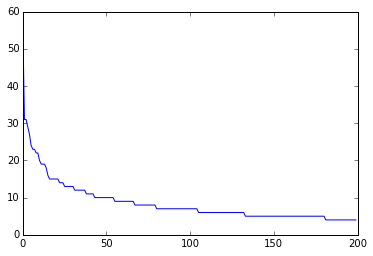

In [121]:
# 結果の表示
for i in range(0, 50):
    print count_list[i][0] ,len(count_list[i][1])

plt.plot(count_number[0:200])